# Result Plot

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches

sns.set_style("ticks")
font = {
    "font.family": "Roboto",
    "font.size": 12,
}
sns.set_style(font)
paper_rc = {
    "lines.linewidth": 3,
    "lines.markersize": 10,
}
sns.set_context("paper", font_scale=1.6, rc=paper_rc)
cmp = sns.color_palette("tab10")

def autolabel_h(rects, ax, prec=2):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate(
            f"{width:.{prec}f}",
            xy=(width, rect.get_y() + rect.get_height() / 2),
            xytext=(18, -1),  
            textcoords="offset points",
            ha="center",
            va="center",
            size=13,
        )

SAVEPATH = "./results"

## 1. Fusion Efficiency

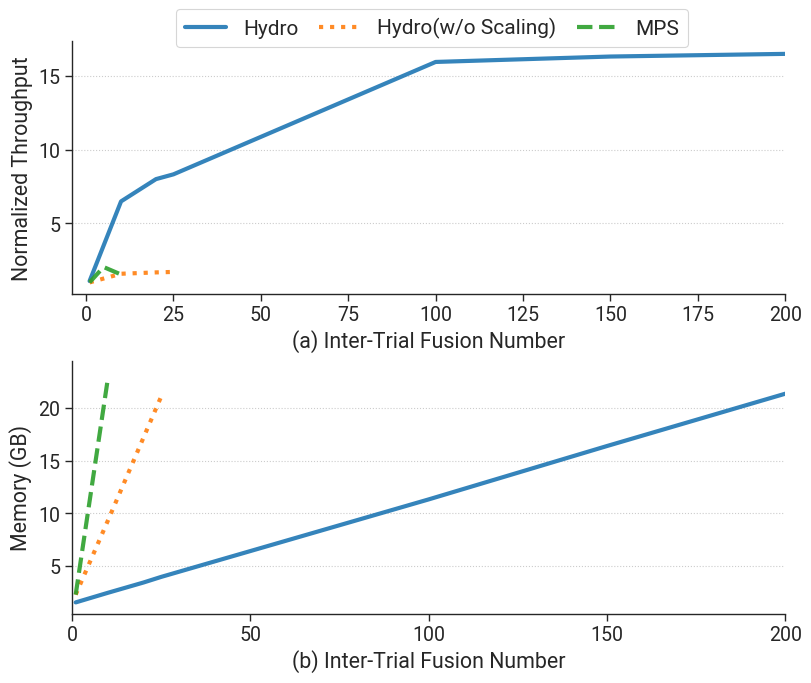

In [2]:
cmp = sns.color_palette("tab10")
grid_params=dict(width_ratios=[1,1])
fig, (ax1,ax2) = plt.subplots(ncols=1, nrows=2, constrained_layout=True, figsize=(8, 6.4))

# -------------------------------------- fig 1 -------------------------------------- 
df = pd.read_csv('./results/resnet18_256.csv')
df_mps = pd.read_csv('./results/resnet18_mps.csv')
record_df = df[(df['amp'] == False) & (df['scale'] == 8)]
record_df_fuse = df[(df['amp'] == False) & (df['scale'] == 1)]
resent18_base = 1 / record_df_fuse['speed(s)'][1]
record_mps = df_mps[(df_mps['bs'] == 256)]

x1 = record_df['fusion'].values
x2 = record_df_fuse['fusion'].values
x3 = record_mps['MPS'].values
speed = (1/record_df['speed(s)'].values) / resent18_base
speed_fuse = (1/record_df_fuse['speed(s)'].values) / resent18_base
speed_mps = (1/record_mps['speed(s)'].values) / resent18_base

y1 = speed*x1
y2 = speed_fuse*x2
y3 = np.insert(speed_mps*x3, 0, y2[0])
x3 = np.insert(x3, 0, x2[0])


ax1.plot(x1, y1, label='resnet18', linewidth=3, color=cmp[0], alpha=0.9, linestyle="-")
ax1.plot(x2, y2, label='resnet18', linewidth=3, color=cmp[1], alpha=0.9, linestyle=":")
ax1.plot(x3, y3, label='resnet18', linewidth=3, color=cmp[2], alpha=0.9, linestyle="--")

ax1.set_xlabel(f"(a) Inter-Trial Fusion Number")
ax1.set_ylabel(f"Normalized Throughput")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(-4, 200)
ax1.grid(axis="y", linestyle=":")

# -------------------------------------- fig 2 -------------------------------------- 

mem = (record_df['gmem'].values) 
mem_fuse = (record_df_fuse['gmem'].values) 
mem_mps = (record_mps['gmem'].values) 
mem_mps = np.insert(mem_mps, 0, mem_fuse[0])

ax2.plot(x1, mem/1024, label='Hydro', linewidth=3, color=cmp[0], alpha=0.9, linestyle="-")
ax2.plot(x2, mem_fuse/1024, label='Hydro(w/o Scaling)', linewidth=3, color=cmp[1], alpha=0.9, linestyle=":")
ax2.plot(x3, mem_mps/1024, label='MPS', linewidth=3, color=cmp[2], alpha=0.9, linestyle="--")

ax2.set_xlabel(f"(b) Inter-Trial Fusion Number")
ax2.set_ylabel(f"Memory (GB)")

ax2.grid(axis="y", linestyle=":")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlim(0, 200)
ax2.set_xticks([0, 50, 100, 150, 200])


handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles=handles, 
           ncol=3, 
           columnspacing=1, 
           bbox_to_anchor=(0.2, 1.06), 
           loc=2, 
           fontsize=15,
           frameon=True,)

## 2. Scaling Fidelity

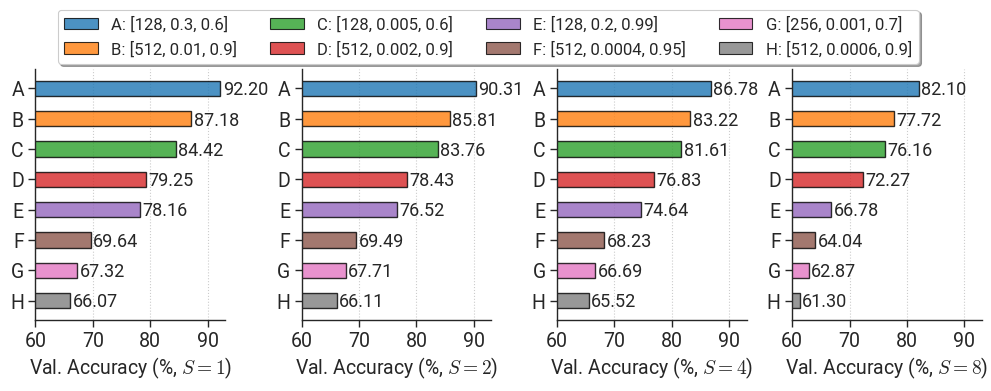

In [3]:
from string import ascii_uppercase
params = {'mathtext.fontset': 'cm' }          
plt.rcParams.update(params)

df = pd.read_csv("./results/scaling_fidelity_seed1.csv")
df["batch_size"] = df["batch_size"].astype(int)
for idx, row in df.iterrows():
    df.at[idx, "config"] = f"[{int(row['batch_size'])}, {row['lr']}, {row['momentum']}]"
ori_df = df[df["scale"] == 1].sort_values("val_acc", ascending=False)
scale_list = df["scale"].unique()
scale_list.sort()
config_list = ori_df["config"].unique()
config_label, color_map = {}, {}
i=0
for (label, config) in zip(list(ascii_uppercase)[:len(config_list)], config_list):
    config_label[config] = label
    color_map[label] = i
    i += 1
df["symbol"] = df["config"].map(config_label)
for idx, row in df.iterrows():
    df.at[idx, "label"] = f"{row['symbol']}: {row['config']}"
ori_df = df[df["scale"] == 1].sort_values("val_acc", ascending=False)


"""Plot"""
ax = []
grid_params = dict(width_ratios=[1, 1, 1, 1])
fig, ax = plt.subplots(ncols=len(scale_list), nrows=1, gridspec_kw=grid_params, constrained_layout=True, figsize=(9.8, 3.2))

y = np.arange(1, len(config_list)+1)
width = 0.5

for i in range(len(scale_list)):
    sub_df = df[df["scale"] == scale_list[i]].sort_values("val_acc", ascending=True)
    colors = [cmp[color_map[label]] for label in sub_df["symbol"]]
    p = ax[i].barh(y, sub_df["val_acc"]*100, height=width, alpha=0.8, linewidth=1, edgecolor="k", color=colors)
    ax[i].set_yticks(y)
    ax[i].set_yticklabels(sub_df["symbol"], fontsize=14)
    ax[i].set_xlabel(f"Val. Accuracy (%, $S={abs(scale_list[i])}$)", fontsize=14)
    ax[i].set_xlim(60, 93)
    ax[i].set_xticks([60, 70, 80, 90])
    ax[i].grid(axis="x", linestyle=":")
    autolabel_h(p, ax[i], 2)


handles, labels = ax[0].get_legend_handles_labels()

patches = []
for i, label in enumerate(ori_df["label"].values):
    patches.append(mpatches.Patch(facecolor=cmp[i], alpha=0.8, edgecolor="black", label=label))

fig.legend(
    handles=patches,
    bbox_to_anchor=(0.94, 1.2),
    ncol=4,
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=12,
)

sns.despine()
fig.savefig(f"{SAVEPATH}/scaling_fidelity.pdf", bbox_inches="tight")